In [83]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import math
import matplotlib
from matplotlib import container
%matplotlib inline

In [84]:
data_dict = {}
data_dict['proposed_orthogonal'] = None
data_dict['he'] = None

N=1000 # number of samples
n=500 # dim of each sample
L=20 # depth of network
B=40


get_mn = lambda x: [i[0] for i in x]
get_std = lambda x: [i[1] for i in x]

In [85]:
data_dict_resnet = {}
data_dict_resnet['proposed_orthogonal'] = None
data_dict_resnet['he'] = None

In [86]:
def get_norm_ratios(init, n0, m0):
    m_layer = list(np.random.randint(m0-50,m0+50,L)) + [n0]
    W = {} # dictionary of weight matrix
    for l in range(L):
        n = m_layer[l-1]
        m = m_layer[l]
        
        if 'He' in init:
            W[l] = np.random.randn(m,n)/np.sqrt(0.5*m) #if l==0 else np.random.randn(m,m)/np.sqrt(0.5*m)
        elif 'orthogonal' in init:
            W_temp = 1.*np.random.randn(m,n) #if l==0 else 1.*np.random.randn(m,m)
            U,_,V = np.linalg.svd(W_temp)
            if W_temp.shape[0]<W_temp.shape[1]:
                W[l] = 1.*V[:W_temp.shape[0]]
            else:
                W[l] = 1.*U[:,:W_temp.shape[1]]
    #         print(m,n,W[l].shape)
        norm = np.linalg.norm(W[l], axis=1)
        W[l] /= norm[:,None]
        if 'Proposed' in init:
            W[l] *= np.sqrt(2*W[l].shape[1]/W[l].shape[0])
        print('Layer {} W-shape {}x{}, true W-shape {}x{}'.format(l, m,n, *W[l].shape))


    epsilon_N_fwd = [ [] for _ in range(L) ]
    epsilon_L_fwd = []

    epsilon_N_bwd = [ [] for _ in range(L) ]
    epsilon_L_bwd = []


    epsilon_N = []
    for N_i in tqdm.tqdm(range(N)):
        x = np.random.randn(m_layer[-1])
        H = []
        H.append(x)
        h=1.*x
        # fwd pass
        for l in range(L):
            R=1.*W[l]
#             print('Fwd layer {}, R {} x {}, h {} '.format(l, *W[l].shape, h.shape[0]))
#             if 'Proposed' in init:
#                 R = 1.*W[l]* np.sqrt(2*R.shape[1]/R.shape[0])
            a = R.dot(h)  
            h = 1.*np.maximum(0,a)
            H.append(h)
            epsilon_N_fwd[l].append( np.linalg.norm(h)/np.linalg.norm(x) )

        delta_x_y = np.random.randn(m_layer[-2])
        grad_a = 1.* delta_x_y
#         epsilon_N_bwd[L-l-1].append(np.linalg.norm(grad_a)/np.linalg.norm(delta_x_y))
        # bwd pass
        for l in range(L-1):
#             print(l,L)
            R=1.*W[L-l-1]
#             if 'Proposed' in init:
#                 R = 1.*W[L-l-1]* np.sqrt(2*R.shape[0]/R.shape[1])
            grad_a_new = 1.*np.asarray(H[-l-2]>0., dtype='float')* R.T.dot(grad_a)
            epsilon_N_bwd[L-l-2].append(np.linalg.norm(grad_a_new)/np.linalg.norm(delta_x_y))
            grad_a = 1.* grad_a_new

    mn_list = []
    for l in range(L):
        mn,std = np.mean(epsilon_N_fwd[l]), np.std(epsilon_N_fwd[l])
        epsilon_L_fwd.append((mn,std))
        mn,std = np.mean(epsilon_N_bwd[l]), np.std(epsilon_N_bwd[l])
        epsilon_L_bwd.append((mn,std))


    return epsilon_L_fwd, epsilon_L_bwd



In [87]:
# PICK INITIALIZATION
# init = ['he', 'glorot', 'gaussian1', 'orthogonal', 'proposed_orthogonal'][-1]
init_list = ['He', 'Proposed (orthogonal)', 'Proposed (He)']
m_list = [200, 1000]
for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        data_dict[name] = get_norm_ratios(init,n, m)



  3%|▎         | 30/1000 [00:00<00:03, 299.03it/s]

Layer 0 W-shape 188x500, true W-shape 188x500
Layer 1 W-shape 225x188, true W-shape 225x188
Layer 2 W-shape 218x225, true W-shape 218x225
Layer 3 W-shape 184x218, true W-shape 184x218
Layer 4 W-shape 228x184, true W-shape 228x184
Layer 5 W-shape 202x228, true W-shape 202x228
Layer 6 W-shape 184x202, true W-shape 184x202
Layer 7 W-shape 205x184, true W-shape 205x184
Layer 8 W-shape 203x205, true W-shape 203x205
Layer 9 W-shape 229x203, true W-shape 229x203
Layer 10 W-shape 232x229, true W-shape 232x229
Layer 11 W-shape 226x232, true W-shape 226x232
Layer 12 W-shape 195x226, true W-shape 195x226
Layer 13 W-shape 181x195, true W-shape 181x195
Layer 14 W-shape 224x181, true W-shape 224x181
Layer 15 W-shape 215x224, true W-shape 215x224
Layer 16 W-shape 195x215, true W-shape 195x215
Layer 17 W-shape 225x195, true W-shape 225x195
Layer 18 W-shape 193x225, true W-shape 193x225
Layer 19 W-shape 195x193, true W-shape 195x193



100%|██████████| 1000/1000 [00:02<00:00, 351.56it/s]

Layer 0 W-shape 961x500, true W-shape 961x500
Layer 1 W-shape 1032x961, true W-shape 1032x961
Layer 2 W-shape 1042x1032, true W-shape 1042x1032
Layer 3 W-shape 1037x1042, true W-shape 1037x1042
Layer 4 W-shape 1024x1037, true W-shape 1024x1037
Layer 5 W-shape 1015x1024, true W-shape 1015x1024
Layer 6 W-shape 982x1015, true W-shape 982x1015
Layer 7 W-shape 1008x982, true W-shape 1008x982
Layer 8 W-shape 1049x1008, true W-shape 1049x1008
Layer 9 W-shape 955x1049, true W-shape 955x1049
Layer 10 W-shape 976x955, true W-shape 976x955
Layer 11 W-shape 977x976, true W-shape 977x976
Layer 12 W-shape 978x977, true W-shape 978x977
Layer 13 W-shape 996x978, true W-shape 996x978
Layer 14 W-shape 1018x996, true W-shape 1018x996
Layer 15 W-shape 973x1018, true W-shape 973x1018
Layer 16 W-shape 1013x973, true W-shape 1013x973



  0%|          | 0/1000 [00:00<?, ?it/s]

Layer 17 W-shape 1027x1013, true W-shape 1027x1013
Layer 18 W-shape 1011x1027, true W-shape 1011x1027
Layer 19 W-shape 965x1011, true W-shape 965x1011



 26%|██▌       | 255/1000 [00:25<01:11, 10.38it/s]


 56%|█████▌    | 556/1000 [00:53<00:42, 10.48it/s]


 83%|████████▎ | 827/1000 [01:20<00:22,  7.70it/s]


100%|██████████| 1000/1000 [01:38<00:00,  6.87it/s]

Layer 0 W-shape 219x500, true W-shape 219x500
Layer 1 W-shape 159x219, true W-shape 159x219
Layer 2 W-shape 161x159, true W-shape 161x159
Layer 3 W-shape 173x161, true W-shape 173x161
Layer 4 W-shape 153x173, true W-shape 153x173
Layer 5 W-shape 150x153, true W-shape 150x153
Layer 6 W-shape 158x150, true W-shape 158x150
Layer 7 W-shape 200x158, true W-shape 200x158
Layer 8 W-shape 218x200, true W-shape 218x200
Layer 9 W-shape 223x218, true W-shape 223x218
Layer 10 W-shape 243x223, true W-shape 243x223
Layer 11 W-shape 214x243, true W-shape 214x243
Layer 12 W-shape 150x214, true W-shape 150x214



  4%|▎         | 37/1000 [00:00<00:02, 364.72it/s]

Layer 13 W-shape 247x150, true W-shape 247x150
Layer 14 W-shape 163x247, true W-shape 163x247
Layer 15 W-shape 178x163, true W-shape 178x163
Layer 16 W-shape 173x178, true W-shape 173x178
Layer 17 W-shape 208x173, true W-shape 208x173
Layer 18 W-shape 203x208, true W-shape 203x208
Layer 19 W-shape 223x203, true W-shape 223x203



100%|██████████| 1000/1000 [00:02<00:00, 334.91it/s]

Layer 0 W-shape 1020x500, true W-shape 1020x500
Layer 1 W-shape 1038x1020, true W-shape 1038x1020
Layer 2 W-shape 1041x1038, true W-shape 1041x1038
Layer 3 W-shape 1028x1041, true W-shape 1028x1041
Layer 4 W-shape 972x1028, true W-shape 972x1028
Layer 5 W-shape 964x972, true W-shape 964x972
Layer 6 W-shape 980x964, true W-shape 980x964
Layer 7 W-shape 1039x980, true W-shape 1039x980
Layer 8 W-shape 975x1039, true W-shape 975x1039
Layer 9 W-shape 990x975, true W-shape 990x975
Layer 10 W-shape 1045x990, true W-shape 1045x990
Layer 11 W-shape 1044x1045, true W-shape 1044x1045
Layer 12 W-shape 964x1044, true W-shape 964x1044
Layer 13 W-shape 1032x964, true W-shape 1032x964
Layer 14 W-shape 982x1032, true W-shape 982x1032
Layer 15 W-shape 957x982, true W-shape 957x982
Layer 16 W-shape 1034x957, true W-shape 1034x957
Layer 17 W-shape 967x1034, true W-shape 967x1034
Layer 18 W-shape 967x967, true W-shape 967x967



  0%|          | 1/1000 [00:00<01:46,  9.35it/s]

Layer 19 W-shape 1036x967, true W-shape 1036x967



 28%|██▊       | 283/1000 [00:27<01:04, 11.06it/s]


 57%|█████▋    | 566/1000 [00:53<00:38, 11.26it/s]


 86%|████████▌ | 859/1000 [01:21<00:13, 10.62it/s]


  4%|▎         | 35/1000 [00:00<00:02, 348.29it/s]

Layer 0 W-shape 203x500, true W-shape 203x500
Layer 1 W-shape 209x203, true W-shape 209x203
Layer 2 W-shape 230x209, true W-shape 230x209
Layer 3 W-shape 233x230, true W-shape 233x230
Layer 4 W-shape 226x233, true W-shape 226x233
Layer 5 W-shape 162x226, true W-shape 162x226
Layer 6 W-shape 193x162, true W-shape 193x162
Layer 7 W-shape 190x193, true W-shape 190x193
Layer 8 W-shape 219x190, true W-shape 219x190
Layer 9 W-shape 174x219, true W-shape 174x219
Layer 10 W-shape 233x174, true W-shape 233x174
Layer 11 W-shape 150x233, true W-shape 150x233
Layer 12 W-shape 208x150, true W-shape 208x150
Layer 13 W-shape 153x208, true W-shape 153x208
Layer 14 W-shape 160x153, true W-shape 160x153
Layer 15 W-shape 210x160, true W-shape 210x160
Layer 16 W-shape 173x210, true W-shape 173x210
Layer 17 W-shape 242x173, true W-shape 242x173
Layer 18 W-shape 246x242, true W-shape 246x242
Layer 19 W-shape 199x246, true W-shape 199x246



100%|██████████| 1000/1000 [00:02<00:00, 362.23it/s]

Layer 0 W-shape 970x500, true W-shape 970x500
Layer 1 W-shape 992x970, true W-shape 992x970
Layer 2 W-shape 983x992, true W-shape 983x992
Layer 3 W-shape 1022x983, true W-shape 1022x983
Layer 4 W-shape 981x1022, true W-shape 981x1022
Layer 5 W-shape 979x981, true W-shape 979x981
Layer 6 W-shape 978x979, true W-shape 978x979
Layer 7 W-shape 953x978, true W-shape 953x978
Layer 8 W-shape 1006x953, true W-shape 1006x953
Layer 9 W-shape 962x1006, true W-shape 962x1006
Layer 10 W-shape 985x962, true W-shape 985x962
Layer 11 W-shape 1023x985, true W-shape 1023x985
Layer 12 W-shape 963x1023, true W-shape 963x1023
Layer 13 W-shape 1043x963, true W-shape 1043x963
Layer 14 W-shape 1027x1043, true W-shape 1027x1043
Layer 15 W-shape 983x1027, true W-shape 983x1027



  0%|          | 0/1000 [00:00<?, ?it/s]

Layer 16 W-shape 1037x983, true W-shape 1037x983
Layer 17 W-shape 1049x1037, true W-shape 1049x1037
Layer 18 W-shape 1029x1049, true W-shape 1029x1049
Layer 19 W-shape 1042x1029, true W-shape 1042x1029



 30%|███       | 304/1000 [00:26<00:59, 11.61it/s]


 60%|██████    | 600/1000 [00:53<00:35, 11.13it/s]


 90%|█████████ | 901/1000 [01:20<00:08, 11.60it/s]


100%|██████████| 1000/1000 [01:29<00:00, 11.16it/s]

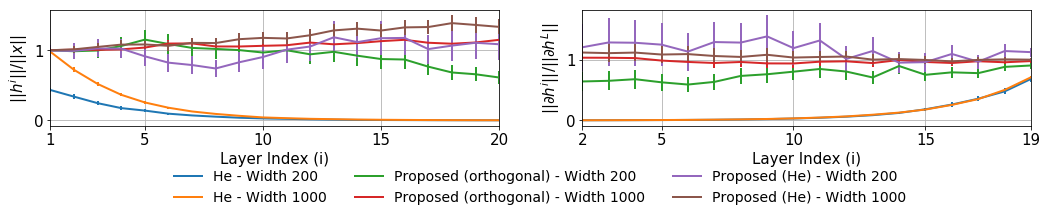

In [88]:
font_size = 14

init_list = ['He', 'Proposed (orthogonal)', 'Proposed (He)']
m_list = [200,1000]
matplotlib.rcParams.update({'font.size': 15})

fig, axarr = plt.subplots(1, 2, figsize=(15, 3))

for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        epsilon_L_fwd, epsilon_L_bwd = data_dict[name]
        axarr[0].errorbar(range(1,1+len(epsilon_L_fwd)),get_mn(epsilon_L_fwd), get_std(epsilon_L_fwd), label=init \
                     + ' - Width ' + str(m), linewidth=2)
        
        axarr[1].errorbar(range(2,2+len(epsilon_L_bwd)-1),get_mn(epsilon_L_bwd)[1:], get_std(epsilon_L_bwd)[1:], label=init \
                     + ' - Width ' + str(m), linewidth=2)
# plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.7), ncol=3)
axarr[0].grid('on')
axarr[1].grid('on')
axarr[0].set_xlabel('Layer Index (i)')
axarr[0].set_ylabel('$||h^i||/||x||$')
axarr[1].set_xlabel('Layer Index (i)')
axarr[1].set_ylabel('$||\partial h^i||/||\partial h^L||$')


axarr[0].set_xlim(1, 20)
fwd_ticks = [1] + list(range(5, len(epsilon_L_fwd) + 1, 5))
bwd_ticks = [2] + list(range(5, len(epsilon_L_bwd[1:]) + 1, 5)) + [19]
axarr[0].set_xticks(fwd_ticks)
axarr[0].set_xticklabels(fwd_ticks)
axarr[1].set_xlim(2, 19)
axarr[1].set_xticks(bwd_ticks)
axarr[1].set_xticklabels(bwd_ticks)
        
        
# Legend
handles, labels = axarr[1].get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
handles = new_handles
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: legend_sorter(t[0])))
fig.legend(handles, labels, loc='center', 
           bbox_to_anchor=(0.50, 0.115),
           ncol=3, fancybox=False, 
           shadow=False, frameon=False,
           fontsize=font_size)

fig.tight_layout()
# fig.subplots_adjust(left=0.2, right=0.8)
fig.subplots_adjust(bottom=0.375)

In [89]:
def F(W, h):
    R=1.*W[0]
    a = R.dot(h)  
    h_r = 1.*np.maximum(0,a)
    R=1.*W[1]
    a = R.dot(h_r)  
    return a

def grad_F(W_b, h_b_minus_1, delta_b):
    h_b_minus_1_next = np.maximum(0,W_b[0].dot(h_b_minus_1))
    
    R=1.*W_b[1]
#     print(h_b_minus_1_next.shape, R.shape, delta_b.shape)
    delta_b_new = R.T.dot(delta_b)
    R=1.*W_b[0]
    delta_b_new = 1.*np.asarray(h_b_minus_1>0., dtype='float')* R.T.dot(delta_b_new) 
    return delta_b_new

def get_norm_ratios_resnet(init, n0, m0, B):
    W = {} # dictionary of weight matrix
    for l in range(B):
        
        if 'He' in init:
            W[l] = [np.random.randn(m0,n0)/np.sqrt(0.5*m0), np.random.randn(n0,m0)/np.sqrt(0.5*n0)]
        elif 'orthogonal' in init:
            W_temp0 = 1.*np.random.randn(m0,n0) 
            U0,_,V0 = np.linalg.svd(W_temp0)
            
            W_temp1 = 1.*np.random.randn(n0,m0) 
            U1,_,V1 = np.linalg.svd(W_temp1)
            
            if W_temp0.shape[0]<W_temp0.shape[1]:
                R0 = 1.*V0[:W_temp0.shape[0]]
            else:
                R0 = 1.*U0[:,:W_temp0.shape[1]]
                
            if W_temp1.shape[0]<W_temp1.shape[1]:
                R1 = 1.*V1[:W_temp1.shape[0]]
            else:
                R1 = 1.*U1[:,:W_temp1.shape[1]]
            W[l] = [R0, R1]
        norm = np.linalg.norm(W[l][0], axis=1)
        W[l][0] /= norm[:,None]
        norm = np.linalg.norm(W[l][1], axis=1)
        W[l][1] /= norm[:,None]
        if 'Proposed' in init:
            fac = 1./np.sqrt(B)
            W[l][0] *= np.sqrt(2*W[l][0].shape[1]/W[l][0].shape[0])
            W[l][1] *= fac*np.sqrt(W[l][1].shape[1]/W[l][1].shape[0])
        print('Layer {} W0-shape {}x{}, W1-shape {}x{}'.format(l, *W[l][0].shape, *W[l][1].shape))


    epsilon_N_fwd = [ [] for _ in range(B) ]
    epsilon_L_fwd = []

    epsilon_N_bwd = [ [] for _ in range(B) ]
    epsilon_L_bwd = []


    epsilon_N = []
    for N_i in tqdm.tqdm(range(N)):
        x = np.random.randn(n0)
        H = []
        H.append(x)
        h=1.*x
        # fwd pass
        for l in range(B):
            Fh = 1.*F(W[l], h)
            h = 1.*(h+Fh)
            H.append(h)
            epsilon_N_fwd[l].append( np.linalg.norm(h)/np.linalg.norm(x) )

        delta_x_y = np.random.randn(n0)
        grad_a = 1.* delta_x_y
        # bwd pass
        for l in range(B-1):
            grad_a_new = grad_a + 1.*grad_F(W[B-l-1], H[-l-2], grad_a)
            epsilon_N_bwd[B-l-2].append(np.linalg.norm(grad_a_new)/np.linalg.norm(delta_x_y))
            grad_a = 1.* grad_a_new

    mn_list = []
    for l in range(B):
        mn,std = np.mean(epsilon_N_fwd[l]), np.std(epsilon_N_fwd[l])
        epsilon_L_fwd.append((mn,std))
        mn,std = np.mean(epsilon_N_bwd[l]), np.std(epsilon_N_bwd[l])
        epsilon_L_bwd.append((mn,std))


    return epsilon_L_fwd, epsilon_L_bwd



In [90]:
# PICK INITIALIZATION
init_list = ['He', 'Proposed (orthogonal)', 'Proposed (He)']
m_list = [200, 1000]
for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        data_dict_resnet[name] = get_norm_ratios_resnet(init,n, m, B)


Layer 0 W0-shape 200x500, W1-shape 500x200
Layer 1 W0-shape 200x500, W1-shape 500x200
Layer 2 W0-shape 200x500, W1-shape 500x200
Layer 3 W0-shape 200x500, W1-shape 500x200
Layer 4 W0-shape 200x500, W1-shape 500x200
Layer 5 W0-shape 200x500, W1-shape 500x200
Layer 6 W0-shape 200x500, W1-shape 500x200
Layer 7 W0-shape 200x500, W1-shape 500x200
Layer 8 W0-shape 200x500, W1-shape 500x200
Layer 9 W0-shape 200x500, W1-shape 500x200
Layer 10 W0-shape 200x500, W1-shape 500x200
Layer 11 W0-shape 200x500, W1-shape 500x200
Layer 12 W0-shape 200x500, W1-shape 500x200
Layer 13 W0-shape 200x500, W1-shape 500x200
Layer 14 W0-shape 200x500, W1-shape 500x200
Layer 15 W0-shape 200x500, W1-shape 500x200
Layer 16 W0-shape 200x500, W1-shape 500x200
Layer 17 W0-shape 200x500, W1-shape 500x200
Layer 18 W0-shape 200x500, W1-shape 500x200
Layer 19 W0-shape 200x500, W1-shape 500x200
Layer 20 W0-shape 200x500, W1-shape 500x200
Layer 21 W0-shape 200x500, W1-shape 500x200
Layer 22 W0-shape 200x500, W1-shape 500x20


  0%|          | 0/1000 [00:00<?, ?it/s]

Layer 26 W0-shape 200x500, W1-shape 500x200
Layer 27 W0-shape 200x500, W1-shape 500x200
Layer 28 W0-shape 200x500, W1-shape 500x200
Layer 29 W0-shape 200x500, W1-shape 500x200
Layer 30 W0-shape 200x500, W1-shape 500x200
Layer 31 W0-shape 200x500, W1-shape 500x200
Layer 32 W0-shape 200x500, W1-shape 500x200
Layer 33 W0-shape 200x500, W1-shape 500x200
Layer 34 W0-shape 200x500, W1-shape 500x200
Layer 35 W0-shape 200x500, W1-shape 500x200
Layer 36 W0-shape 200x500, W1-shape 500x200
Layer 37 W0-shape 200x500, W1-shape 500x200
Layer 38 W0-shape 200x500, W1-shape 500x200
Layer 39 W0-shape 200x500, W1-shape 500x200



 91%|█████████ | 911/1000 [00:17<00:01, 46.00it/s]


100%|██████████| 1000/1000 [00:19<00:00, 52.58it/s]

Layer 0 W0-shape 1000x500, W1-shape 500x1000
Layer 1 W0-shape 1000x500, W1-shape 500x1000
Layer 2 W0-shape 1000x500, W1-shape 500x1000
Layer 3 W0-shape 1000x500, W1-shape 500x1000
Layer 4 W0-shape 1000x500, W1-shape 500x1000
Layer 5 W0-shape 1000x500, W1-shape 500x1000
Layer 6 W0-shape 1000x500, W1-shape 500x1000
Layer 7 W0-shape 1000x500, W1-shape 500x1000
Layer 8 W0-shape 1000x500, W1-shape 500x1000
Layer 9 W0-shape 1000x500, W1-shape 500x1000
Layer 10 W0-shape 1000x500, W1-shape 500x1000
Layer 11 W0-shape 1000x500, W1-shape 500x1000
Layer 12 W0-shape 1000x500, W1-shape 500x1000
Layer 13 W0-shape 1000x500, W1-shape 500x1000
Layer 14 W0-shape 1000x500, W1-shape 500x1000
Layer 15 W0-shape 1000x500, W1-shape 500x1000
Layer 16 W0-shape 1000x500, W1-shape 500x1000
Layer 17 W0-shape 1000x500, W1-shape 500x1000
Layer 18 W0-shape 1000x500, W1-shape 500x1000
Layer 19 W0-shape 1000x500, W1-shape 500x1000
Layer 20 W0-shape 1000x500, W1-shape 500x1000
Layer 21 W0-shape 1000x500, W1-shape 500x100


  0%|          | 0/1000 [00:00<?, ?it/s]

Layer 34 W0-shape 1000x500, W1-shape 500x1000
Layer 35 W0-shape 1000x500, W1-shape 500x1000
Layer 36 W0-shape 1000x500, W1-shape 500x1000
Layer 37 W0-shape 1000x500, W1-shape 500x1000
Layer 38 W0-shape 1000x500, W1-shape 500x1000
Layer 39 W0-shape 1000x500, W1-shape 500x1000



 15%|█▌        | 153/1000 [00:22<02:01,  6.95it/s]


 30%|███       | 304/1000 [00:44<01:38,  7.07it/s]


 46%|████▌     | 455/1000 [01:06<01:17,  7.07it/s]


 61%|██████    | 606/1000 [01:29<00:55,  7.07it/s]


 76%|███████▌  | 757/1000 [01:53<00:37,  6.52it/s]


 91%|█████████ | 908/1000 [02:16<00:13,  6.80it/s]


100%|██████████| 1000/1000 [02:30<00:00,  6.84it/s]

Layer 0 W0-shape 200x500, W1-shape 500x200
Layer 1 W0-shape 200x500, W1-shape 500x200
Layer 2 W0-shape 200x500, W1-shape 500x200
Layer 3 W0-shape 200x500, W1-shape 500x200
Layer 4 W0-shape 200x500, W1-shape 500x200
Layer 5 W0-shape 200x500, W1-shape 500x200
Layer 6 W0-shape 200x500, W1-shape 500x200
Layer 7 W0-shape 200x500, W1-shape 500x200
Layer 8 W0-shape 200x500, W1-shape 500x200
Layer 9 W0-shape 200x500, W1-shape 500x200
Layer 10 W0-shape 200x500, W1-shape 500x200
Layer 11 W0-shape 200x500, W1-shape 500x200
Layer 12 W0-shape 200x500, W1-shape 500x200
Layer 13 W0-shape 200x500, W1-shape 500x200
Layer 14 W0-shape 200x500, W1-shape 500x200
Layer 15 W0-shape 200x500, W1-shape 500x200
Layer 16 W0-shape 200x500, W1-shape 500x200
Layer 17 W0-shape 200x500, W1-shape 500x200
Layer 18 W0-shape 200x500, W1-shape 500x200
Layer 19 W0-shape 200x500, W1-shape 500x200
Layer 20 W0-shape 200x500, W1-shape 500x200
Layer 21 W0-shape 200x500, W1-shape 500x200
Layer 22 W0-shape 200x500, W1-shape 500x20


  1%|          | 6/1000 [00:00<00:19, 51.90it/s]

Layer 39 W0-shape 200x500, W1-shape 500x200



 88%|████████▊ | 881/1000 [00:17<00:02, 48.46it/s]


100%|██████████| 1000/1000 [00:19<00:00, 50.78it/s]

Layer 0 W0-shape 1000x500, W1-shape 500x1000
Layer 1 W0-shape 1000x500, W1-shape 500x1000
Layer 2 W0-shape 1000x500, W1-shape 500x1000
Layer 3 W0-shape 1000x500, W1-shape 500x1000
Layer 4 W0-shape 1000x500, W1-shape 500x1000
Layer 5 W0-shape 1000x500, W1-shape 500x1000
Layer 6 W0-shape 1000x500, W1-shape 500x1000
Layer 7 W0-shape 1000x500, W1-shape 500x1000
Layer 8 W0-shape 1000x500, W1-shape 500x1000
Layer 9 W0-shape 1000x500, W1-shape 500x1000
Layer 10 W0-shape 1000x500, W1-shape 500x1000
Layer 11 W0-shape 1000x500, W1-shape 500x1000
Layer 12 W0-shape 1000x500, W1-shape 500x1000
Layer 13 W0-shape 1000x500, W1-shape 500x1000
Layer 14 W0-shape 1000x500, W1-shape 500x1000
Layer 15 W0-shape 1000x500, W1-shape 500x1000
Layer 16 W0-shape 1000x500, W1-shape 500x1000
Layer 17 W0-shape 1000x500, W1-shape 500x1000
Layer 18 W0-shape 1000x500, W1-shape 500x1000
Layer 19 W0-shape 1000x500, W1-shape 500x1000
Layer 20 W0-shape 1000x500, W1-shape 500x1000
Layer 21 W0-shape 1000x500, W1-shape 500x100


  0%|          | 1/1000 [00:00<02:56,  5.65it/s]

Layer 39 W0-shape 1000x500, W1-shape 500x1000



 15%|█▌        | 154/1000 [00:26<02:31,  5.57it/s]


 30%|███       | 305/1000 [00:54<02:10,  5.33it/s]


 46%|████▌     | 456/1000 [01:21<01:33,  5.80it/s]


 61%|██████    | 607/1000 [01:48<01:12,  5.42it/s]


 76%|███████▌  | 758/1000 [02:15<00:43,  5.57it/s]


 91%|█████████ | 909/1000 [02:42<00:16,  5.44it/s]


100%|██████████| 1000/1000 [02:59<00:00,  4.92it/s]

Layer 0 W0-shape 200x500, W1-shape 500x200
Layer 1 W0-shape 200x500, W1-shape 500x200
Layer 2 W0-shape 200x500, W1-shape 500x200
Layer 3 W0-shape 200x500, W1-shape 500x200
Layer 4 W0-shape 200x500, W1-shape 500x200
Layer 5 W0-shape 200x500, W1-shape 500x200
Layer 6 W0-shape 200x500, W1-shape 500x200
Layer 7 W0-shape 200x500, W1-shape 500x200
Layer 8 W0-shape 200x500, W1-shape 500x200
Layer 9 W0-shape 200x500, W1-shape 500x200
Layer 10 W0-shape 200x500, W1-shape 500x200
Layer 11 W0-shape 200x500, W1-shape 500x200
Layer 12 W0-shape 200x500, W1-shape 500x200
Layer 13 W0-shape 200x500, W1-shape 500x200
Layer 14 W0-shape 200x500, W1-shape 500x200
Layer 15 W0-shape 200x500, W1-shape 500x200
Layer 16 W0-shape 200x500, W1-shape 500x200
Layer 17 W0-shape 200x500, W1-shape 500x200
Layer 18 W0-shape 200x500, W1-shape 500x200
Layer 19 W0-shape 200x500, W1-shape 500x200
Layer 20 W0-shape 200x500, W1-shape 500x200
Layer 21 W0-shape 200x500, W1-shape 500x200
Layer 22 W0-shape 200x500, W1-shape 500x20


  0%|          | 0/1000 [00:00<?, ?it/s]

Layer 23 W0-shape 200x500, W1-shape 500x200
Layer 24 W0-shape 200x500, W1-shape 500x200
Layer 25 W0-shape 200x500, W1-shape 500x200
Layer 26 W0-shape 200x500, W1-shape 500x200
Layer 27 W0-shape 200x500, W1-shape 500x200
Layer 28 W0-shape 200x500, W1-shape 500x200
Layer 29 W0-shape 200x500, W1-shape 500x200
Layer 30 W0-shape 200x500, W1-shape 500x200
Layer 31 W0-shape 200x500, W1-shape 500x200
Layer 32 W0-shape 200x500, W1-shape 500x200
Layer 33 W0-shape 200x500, W1-shape 500x200
Layer 34 W0-shape 200x500, W1-shape 500x200
Layer 35 W0-shape 200x500, W1-shape 500x200
Layer 36 W0-shape 200x500, W1-shape 500x200
Layer 37 W0-shape 200x500, W1-shape 500x200
Layer 38 W0-shape 200x500, W1-shape 500x200
Layer 39 W0-shape 200x500, W1-shape 500x200



 90%|████████▉ | 896/1000 [00:17<00:02, 50.91it/s]


100%|██████████| 1000/1000 [00:19<00:00, 50.77it/s]

Layer 0 W0-shape 1000x500, W1-shape 500x1000
Layer 1 W0-shape 1000x500, W1-shape 500x1000
Layer 2 W0-shape 1000x500, W1-shape 500x1000
Layer 3 W0-shape 1000x500, W1-shape 500x1000
Layer 4 W0-shape 1000x500, W1-shape 500x1000
Layer 5 W0-shape 1000x500, W1-shape 500x1000
Layer 6 W0-shape 1000x500, W1-shape 500x1000
Layer 7 W0-shape 1000x500, W1-shape 500x1000
Layer 8 W0-shape 1000x500, W1-shape 500x1000
Layer 9 W0-shape 1000x500, W1-shape 500x1000
Layer 10 W0-shape 1000x500, W1-shape 500x1000
Layer 11 W0-shape 1000x500, W1-shape 500x1000
Layer 12 W0-shape 1000x500, W1-shape 500x1000
Layer 13 W0-shape 1000x500, W1-shape 500x1000
Layer 14 W0-shape 1000x500, W1-shape 500x1000
Layer 15 W0-shape 1000x500, W1-shape 500x1000
Layer 16 W0-shape 1000x500, W1-shape 500x1000
Layer 17 W0-shape 1000x500, W1-shape 500x1000
Layer 18 W0-shape 1000x500, W1-shape 500x1000
Layer 19 W0-shape 1000x500, W1-shape 500x1000
Layer 20 W0-shape 1000x500, W1-shape 500x1000
Layer 21 W0-shape 1000x500, W1-shape 500x100


  0%|          | 1/1000 [00:00<02:17,  7.27it/s]

Layer 39 W0-shape 1000x500, W1-shape 500x1000



 15%|█▌        | 154/1000 [00:22<02:01,  6.95it/s]


 30%|███       | 305/1000 [00:44<01:39,  6.96it/s]


 46%|████▌     | 456/1000 [01:06<01:20,  6.78it/s]


 61%|██████    | 607/1000 [01:29<01:00,  6.49it/s]


 76%|███████▌  | 758/1000 [01:52<00:37,  6.49it/s]


 91%|█████████ | 909/1000 [02:14<00:13,  6.83it/s]


100%|██████████| 1000/1000 [02:28<00:00,  6.80it/s]

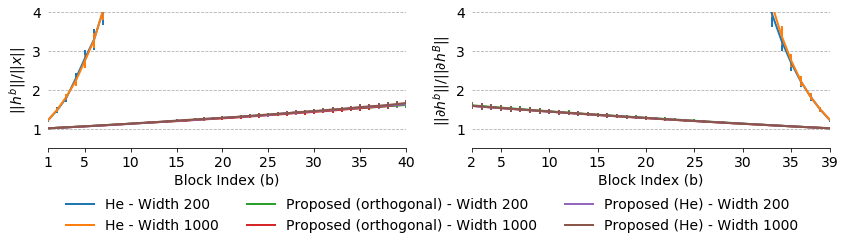

In [91]:
font_size = 14

init_list = ['He', 'Proposed (orthogonal)', 'Proposed (He)']
m_list = [200,1000]


fig, axarr = plt.subplots(1, 2, figsize=(2 * 6, 3.5))

for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        epsilon_L_fwd, epsilon_L_bwd = data_dict_resnet[name]
        axarr[0].errorbar(range(1,1+len(epsilon_L_fwd)),get_mn(epsilon_L_fwd), get_std(epsilon_L_fwd), label=init \
                     + ' - Width ' + str(m), linewidth=2)
        
        axarr[1].errorbar(range(2,2+len(epsilon_L_bwd[1:])),get_mn(epsilon_L_bwd)[1:], get_std(epsilon_L_bwd)[1:], label=init \
                     + ' - Width ' + str(m), linewidth=2)
# plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.7), ncol=3)
# axarr[0].grid('on')
# axarr[1].grid('on')
axarr[0].set_xlabel('Block Index (b)')
axarr[0].set_ylabel('$||h^b||/||x||$')
axarr[1].set_xlabel('Block Index (b)')
axarr[1].set_ylabel('$||\partial h^b||/||\partial h^B||$')


# Make plots nicer
for ax in axarr:
    for p in ['left', 'right', 'top']:
        ax.spines[p].set_color('none')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylim([0.5,4])
    ax.set_yticks(np.arange(1,5,1))
    ax.set_yticklabels(np.arange(1,5,1))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('none')
    ax.yaxis.grid(linestyle='--')
    ax.minorticks_off()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size)
axarr[0].set_xlim(1, 40)
fwd_ticks = [1] + list(range(5, len(epsilon_L_fwd) + 1, 5))
bwd_ticks = [2] + list(range(5, len(epsilon_L_bwd[1:]) + 1, 5)) + [39]
axarr[0].set_xticks(fwd_ticks)
axarr[0].set_xticklabels(fwd_ticks)
axarr[1].set_xlim(2, 39)
axarr[1].set_xticks(bwd_ticks)
axarr[1].set_xticklabels(bwd_ticks)
        
        
# Legend
handles, labels = axarr[1].get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
handles = new_handles
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: legend_sorter(t[0])))
fig.legend(handles, labels, loc='center', 
           bbox_to_anchor=(0.50, 0.115),
           ncol=3, fancybox=False, 
           shadow=False, frameon=False,
           fontsize=font_size)

fig.tight_layout()
# fig.subplots_adjust(left=0.2, right=0.8)
fig.subplots_adjust(bottom=0.375)



## Combined plots

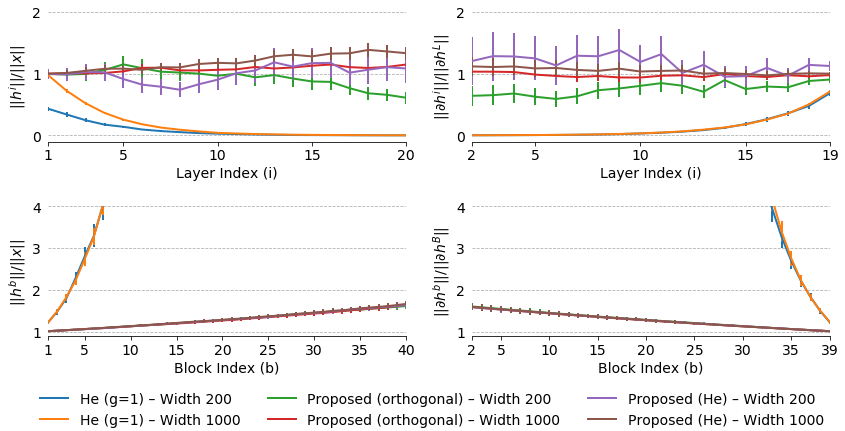

In [116]:
font_size = 14

init_list = ['He', 'Proposed (orthogonal)', 'Proposed (He)']
labels = {x: x for x in init_list}
labels['He'] = 'He (g=1)'
m_list = [200,1000]

fig, axarr_all = plt.subplots(2, 2, figsize=(12, 6))

axarr = axarr_all[0]

for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        epsilon_L_fwd, epsilon_L_bwd = data_dict[name]
        axarr[0].errorbar(range(1,1+len(epsilon_L_fwd)),get_mn(epsilon_L_fwd), get_std(epsilon_L_fwd), 
                          label=labels[init] + ' – Width ' + str(m), linewidth=2)
        
        axarr[1].errorbar(range(2,2+len(epsilon_L_bwd)-1),get_mn(epsilon_L_bwd)[1:], get_std(epsilon_L_bwd)[1:], 
                          label=labels[init] + ' – Width ' + str(m), linewidth=2)
# plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.7), ncol=3)
# axarr[0].grid('on')
# axarr[1].grid('on')
axarr[0].set_xlabel('Layer Index (i)')
axarr[0].set_ylabel('$||h^i||/||x||$')
axarr[1].set_xlabel('Layer Index (i)')
axarr[1].set_ylabel('$||\partial h^i||/||\partial h^L||$')


axarr[0].set_xlim(1, 20)
fwd_ticks = [1] + list(range(5, len(epsilon_L_fwd) + 1, 5))
bwd_ticks = [2] + list(range(5, len(epsilon_L_bwd[1:]) + 1, 5)) + [19]
axarr[0].set_xticks(fwd_ticks)
axarr[0].set_xticklabels(fwd_ticks)
axarr[1].set_xlim(2, 19)
axarr[1].set_xticks(bwd_ticks)
axarr[1].set_xticklabels(bwd_ticks)

for ax in axarr:
    ax.set_ylim([-0.1,2])
    ax.set_yticks(np.arange(0,3,1))
    ax.set_yticklabels(np.arange(0,3,1))

axarr = axarr_all[1]

for init in init_list:
    for m in m_list:
        name = init + '_' + str(m)
        epsilon_L_fwd, epsilon_L_bwd = data_dict_resnet[name]
        axarr[0].errorbar(range(1,1+len(epsilon_L_fwd)),get_mn(epsilon_L_fwd), get_std(epsilon_L_fwd), 
                          label=labels[init] + ' – Width ' + str(m), linewidth=2)
        
        axarr[1].errorbar(range(2,2+len(epsilon_L_bwd[1:])),get_mn(epsilon_L_bwd)[1:], get_std(epsilon_L_bwd)[1:], 
                          label=labels[init] + ' – Width ' + str(m), linewidth=2)
# plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.7), ncol=3)
# axarr[0].grid('on')
# axarr[1].grid('on')
axarr[0].set_xlabel('Block Index (b)')
axarr[0].set_ylabel('$||h^b||/||x||$')
axarr[1].set_xlabel('Block Index (b)')
axarr[1].set_ylabel('$||\partial h^b||/||\partial h^B||$')


# Make plots nicer
for axarr in axarr_all:
    for ax in axarr:
        for p in ['left', 'right', 'top']:
            ax.spines[p].set_color('none')
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.yaxis.grid(linestyle='--')
        ax.minorticks_off()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(font_size)
            
for ax in axarr:
    ax.set_ylim([0.9,4])
    ax.set_yticks(np.arange(1,5,1))
    ax.set_yticklabels(np.arange(1,5,1))
axarr[0].set_xlim(1, 40)
fwd_ticks = [1] + list(range(5, len(epsilon_L_fwd) + 1, 5))
bwd_ticks = [2] + list(range(5, len(epsilon_L_bwd[1:]) + 1, 5)) + [39]
axarr[0].set_xticks(fwd_ticks)
axarr[0].set_xticklabels(fwd_ticks)
axarr[1].set_xlim(2, 39)
axarr[1].set_xticks(bwd_ticks)
axarr[1].set_xticklabels(bwd_ticks)
        
        
# Legend
handles, labels = axarr[1].get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
handles = new_handles
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: legend_sorter(t[0])))
fig.legend(handles, labels, loc='center', 
           bbox_to_anchor=(0.50, 0.05),
           ncol=3, fancybox=False, 
           shadow=False, frameon=False,
           fontsize=font_size)

fig.tight_layout()
fig.subplots_adjust(bottom=0.20, hspace=0.5)
